In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')

In [57]:
def obj_handle(df):
    for col in ['MSSubClass', 'YrSold', 'MoSold']:
        df[col] = df[col].astype(object)
    return df




def most_common(lst):
    return max(set(lst), key=lst.count)
def na_handler(df):
    df['PoolQC']=df['PoolQC'].fillna('No Pool')
    df['MiscFeature']=df['MiscFeature'].fillna('noAdd')
    df['Alley']=df['Alley'].fillna('NoAccess')
    df['Fence']=df['Fence'].fillna('NoFence')
    df['FireplaceQu']=df['FireplaceQu'].fillna('NoFireplace')
    df['GarageCond']=df['GarageCond'].fillna('noG')
    df['BsmtExposure']=df['BsmtExposure'].fillna('NoB')
    df['MasVnrType']=df['MasVnrType'].fillna('noM')
    df['Electrical']=df['Electrical'].fillna(most_common(df['Electrical'].tolist()))
    return df




def float_handle(dff):
    dff['LotAreaAdditional']=dff['LotAreaAdditional'].fillna(0)
    dff=dff.drop('YearReconstruction',axis=1)
    dff=dff.drop('Variable01',axis=1)
    dff=dff.drop('Variable02',axis=1)
    dff=dff.drop('Variable03',axis=1)
    dff=dff.drop('Variable04',axis=1)
    dff=dff.drop('Variable05',axis=1)
    dff=dff.drop('3rdFlrSF',axis=1)
    dff['LotFrontage']=dff['LotFrontage'].fillna(dff['LotFrontage'].mean())
    dff['GarageYrBlt']=dff['GarageYrBlt'].fillna(min(dff['GarageYrBlt']))
    dff['MasVnrArea']=dff['MasVnrArea'].fillna(0)
    return dff
def years_to_age(dff):
    dff['YrSold']=dff['YrSold'].apply(lambda x: 2010-x)

    dff['YearBuilt']=dff['YearBuilt'].apply(lambda x: 2010-x)
    dff['YearRemodAdd']=dff['YearRemodAdd'].apply(lambda x: 2010-x)
    dff['GarageYrBlt']=dff['GarageYrBlt'].apply(lambda x: 2010-x)
    return dff

    

In [58]:
def make_model_data(df,trainn=True,regr_qual = RandomForestClassifier(),ohe = OneHotEncoder(sparse=False,handle_unknown='ignore'),
      ohe1 = OneHotEncoder(sparse=False,handle_unknown='ignore')):
    df=obj_handle(df)
    df=float_handle(df)
    df=na_handler(df)
    df=years_to_age(df)
    df['OverallQual']=df['OverallQual'].astype('str').apply(lambda x: ''.join([i for i in x if i not in '!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~']) )
    df['OverallQual']=df['OverallQual'].astype('float')
    popped=df.pop('OverallQual')
    df_obj=df.select_dtypes(include=['object'])
    
    for col in ['GarageType', 'GarageQual', 'GarageFinish', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtCond', 'BsmtQual']:
        df_obj[col] = df_obj[col].fillna(str(0))
    if trainn==True:
        array_hot_encoded = ohe.fit_transform(df_obj)
        column_name = ohe.get_feature_names()

        data_hot_encoded = pd.DataFrame(array_hot_encoded, index=df_obj.index,columns= column_name)

    else:
        array_hot_encoded = ohe.transform(df_obj)
        column_name = ohe.get_feature_names()
        data_hot_encoded = pd.DataFrame(array_hot_encoded, index=df_obj.index,columns= column_name)

    
    
    df_ok=df.select_dtypes(include=['int64'])
    df_1=pd.concat([df_ok,data_hot_encoded], axis=1)
    try:
        SalePrice=df_1.pop('SalePrice')
        Y=SalePrice.values.tolist()
    except:
        Y=[0]
    if trainn==True:
        df_1['OverallQual']=popped
        df_1['OverallQual']=df_1['OverallQual'].fillna(123)
        df2=df_1.loc[df_1['OverallQual']!=123]
        df3=df_1.loc[df_1['OverallQual']==123]

        y=df2.pop('OverallQual')

        regr_qual = RandomForestClassifier()
        regr_qual.fit(df2, y)
        df3.pop('OverallQual')
        predictions=regr_qual.predict(df3)
        df2['OverallQual']=y
        df3['OverallQual']=predictions.tolist()
        df_1=pd.concat([df2,df3],axis=0)
        df_1.sort_index(inplace=True)
        array_hot_encoded = ohe1.fit_transform(df_1['OverallQual'].values.reshape(-1, 1))
        column_name = ohe1.get_feature_names()

        data_hot_encoded = pd.DataFrame(array_hot_encoded, index=df_obj.index,columns= column_name)
        df_1=pd.concat([df_1,data_hot_encoded], axis=1)
        df_1.pop('OverallQual')
        df_1['TotalArea'] = df_1['TotalBsmtSF'] + df_1['1stFlrSF'] + df_1['2ndFlrSF'] +  df_1['GrLivArea'] +df_1['GarageArea']
        df_1['Bathrooms'] = df_1['FullBath'] + df_1['HalfBath']/2
        df_1['Year average']= (df_1['YearRemodAdd']+df_1['YearBuilt'])/2
        return df_1,Y,regr_qual,ohe,ohe1,df_obj
    else:
        df_1['OverallQual']=popped
        df_1['OverallQual']=df_1['OverallQual'].fillna(123)
        df2=df_1.loc[df_1['OverallQual']!=123]
        df3=df_1.loc[df_1['OverallQual']==123]

        y=df2.pop('OverallQual')

        regr_qual = regr_qual
        df3.pop('OverallQual')
        predictions=regr_qual.predict(df3)
        df2['OverallQual']=y
        df3['OverallQual']=predictions.tolist()
        df_1=pd.concat([df2,df3],axis=0)
        array_hot_encoded = ohe1.transform(df_1['OverallQual'].values.reshape(-1, 1))
        column_name = ohe1.get_feature_names()

        data_hot_encoded = pd.DataFrame(array_hot_encoded, index=df_obj.index,columns= column_name)
        df_1=pd.concat([df_1,data_hot_encoded], axis=1)
        df_1.pop('OverallQual')
        df_1.sort_index(inplace=True)
        df_1['TotalArea'] = df_1['TotalBsmtSF'] + df_1['1stFlrSF'] + df_1['2ndFlrSF']+  df_1['GrLivArea'] +df_1['GarageArea']
        df_1['Bathrooms'] = df_1['FullBath'] + df_1['HalfBath']/2
        df_1['Year average']= (df_1['YearRemodAdd']+df_1['YearBuilt'])/2
        return df_1

In [59]:
df=pd.read_csv(r'C:\Users\Администратор\Desktop\REAskills2021\train.csv')
df=df.drop('Unnamed: 0', axis=1)

df,Y,regr_qual,ohe,ohe1,df_obj=make_model_data(df)

In [60]:
df_test=pd.read_csv(r'C:\Users\Администратор\Desktop\REAskills2021\test.csv')
df_test=df_test.drop('Unnamed: 0', axis=1)
df_test=make_model_data(df=df_test,trainn=False,regr_qual=regr_qual,ohe=ohe,ohe1=ohe1)

<h1> Пробуем фигню </h1>


In [61]:
# from sklearn.preprocessing import RobustScaler, MinMaxScaler

# scaler = RobustScaler()


In [62]:
# X_train_scaled = scaler.fit_transform(df.values)
# df = pd.DataFrame(X_train_scaled, index = df.index, columns= df.columns)

# # # Scale the X_test set
# # X_test_scaled = scaler.transform(test_df.values)
# X_test_df = pd.DataFrame(X_test_scaled, index = test_df.index, columns= test_df.columns)

In [63]:
# from sklearn.feature_selection import VarianceThreshold


In [64]:
# threshold_n=1
# sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
# sel_var=sel.fit_transform(df)

# # Create the new datasets
# df = df[df.columns[sel.get_support(indices=True)]]
# # X_test_df = X_test_df[X_test_df.columns[sel.get_support(indices= True)]]


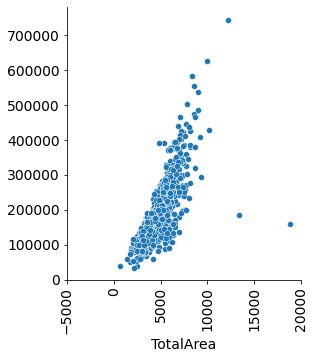

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
re_plot = sns.relplot(y=Y, x= 'TotalArea', legend="full", data=df, height=4.5, aspect=3 / 3,);
re_plot.set_xticklabels(rotation=90)

<h1>ОБУЧЕНИЕ</h1>

In [66]:
# ПРИМЕНЯЕМ ЛОГ, НА ВЫХОДЕ ЭКСПОНЕНТУ!!!!
Y=np.log(Y)
param_grid = {
    'bootstrap': [True],
    'max_depth': [100],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [6,8, 10],
    'n_estimators': [100, 120, 150]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='r2', 
                          cv = 5, n_jobs = -1, verbose = 2)
grid.fit(df, Y)
print(grid.best_params_)
best=grid.best_estimator_
print(grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}
0.8645055916332334


In [67]:
# 0.8469195966738869 до фич инжиниринг

In [92]:
# СУПЕРПРЕДИКТ
import math
def main_pred(regr,df):
    df_test=pd.read_csv(r'C:\Users\Администратор\Desktop\REAskills2021\train.csv')
    df_test=df_test.drop('Unnamed: 0', axis=1)

    df_test=make_model_data(df=df_test,trainn=False,regr_qual=regr_qual,ohe=ohe,ohe1=ohe1)
    predictions=regr.predict(df_test)
    for i in range(len(predictions)):
        predictions[i]=math.exp(predictions[i])
#     predictions.to_csv('preds.csv')
    return predictions

preds=main_pred(best,df)

ValueError: X has 336 features, but DecisionTreeRegressor is expecting 15 features as input.

Text(0.5, 0, 'Random Forest Feature Importance')

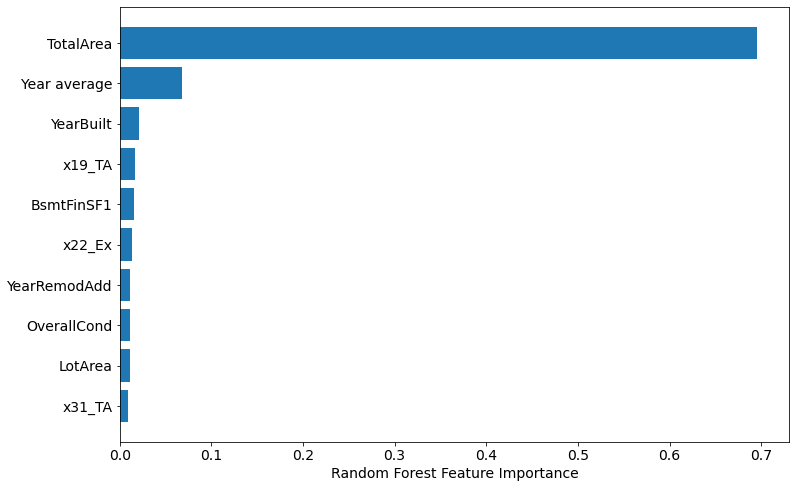

In [69]:
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})
sorted_idx = best.feature_importances_.argsort()
plt.barh(df.columns.values[sorted_idx][-10:], best.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")



In [75]:
# mask=df.columns.values[sorted_idx][-10:].tolist()
mask=['LotArea','OverallCond','YearRemodAdd','BsmtFinSF1','YearBuilt','Year average','TotalArea']
for i in ['x19_Ex', 'x19_Fa', 'x19_Gd','x19_TA']:
    mask.append(i)

for i in ['x22_Ex', 'x22_Fa', 'x22_Gd', 'x22_TA']:
    mask.append(i)


<h1>Модель для Фласка</h1>

In [76]:
df_small=df[mask]

In [77]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [100],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [6,8, 10],
    'n_estimators': [100, 120, 150]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid,scoring='r2',
                          cv = 5, n_jobs = -1, verbose = 2)
grid.fit(df_small, Y)
print(grid.best_params_)
best=grid.best_estimator_
print(grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 150}
0.8564723856719352


In [81]:
rf = RandomForestRegressor(bootstrap=True, max_depth=100,
                            max_features='auto', min_samples_leaf= 4,
                            min_samples_split= 8, n_estimators= 150)
rf.fit(df_small, Y)

import pickle
pickle.dump(rf, open('rf_mdl', 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

In [82]:
df_small

,LotArea,OverallCond,YearRemodAdd,BsmtFinSF1,YearBuilt,Year average,TotalArea,x19_Ex,x19_Fa,x19_Gd,x19_TA,x22_Ex,x22_Fa,x22_Gd,x22_TA
0,10125,5,33,0,33,33.0,4007,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,13350,5,36,762,36,36.0,3092,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,6240,5,4,863,4,4.0,4522,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,12984,6,33,1283,33,33.0,5345,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,5720,6,60,0,69,64.5,3138,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,9317,5,4,24,4,4.0,4382,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1237,7804,3,60,622,82,71.0,5660,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1238,8172,7,20,167,55,37.5,3164,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1239,7642,8,12,0,92,52.0,3980,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [87]:
df_obj.iloc[:,22]

0        0
1       TA
2       Gd
3       Gd
4       TA
        ..
1236    Gd
1237    TA
1238    TA
1239    TA
1240    Gd
Name: BsmtQual, Length: 1241, dtype: object

In [91]:
df=pd.DataFrame([123, '10', 1887, 23, 1887, 123.0, 123, '0', '0', '1', '0', '0', '1', '0', '0']).T

In [95]:
rf.predict(df)[0]

11.052714376881813